### Implementing Meeting Notes 4/5/24

Changes made by Sofia, uploaded to `utils.py`:

Combined the plotting functions to be within the `train_emulator()` function like we did together as a team 4/3/24. I think separating them into functions was causing the extra plot to be called. I don't have a strong grasp as to why, I just don't have that issue when nesting the plotting within the `train_emulator()` function. I adjusted Heather's most recent code for `dashboard_wrangling()` to include these changes and uploaded them into utils, but you can view the workflow below in this notebook.

This workflow loads and plots new data in ~16 seconds.

I corrected the emulator plot to contain predictions on `X_values`, and pulled this variable out of the function to be stored generally in utils. This way, we don't have to recreate it every time. However, it's still not plotting the exact trend we expect, so we need to work on correcting this.

In [1]:
import xarray as xr

In [2]:
from utils import *

In [ ]:
# Request an additional 10 cores of power for processing from the server
client = get_cluster("UCSB0021", cores = 30)
# apply peer2peer network communication across multiple devices
client.cluster

Training R^2: 0.9425140697756845
Training RMSE: 0.04635041296076164
Mean Absolute Error: 0.0363568749639293
Training Score: 1.0


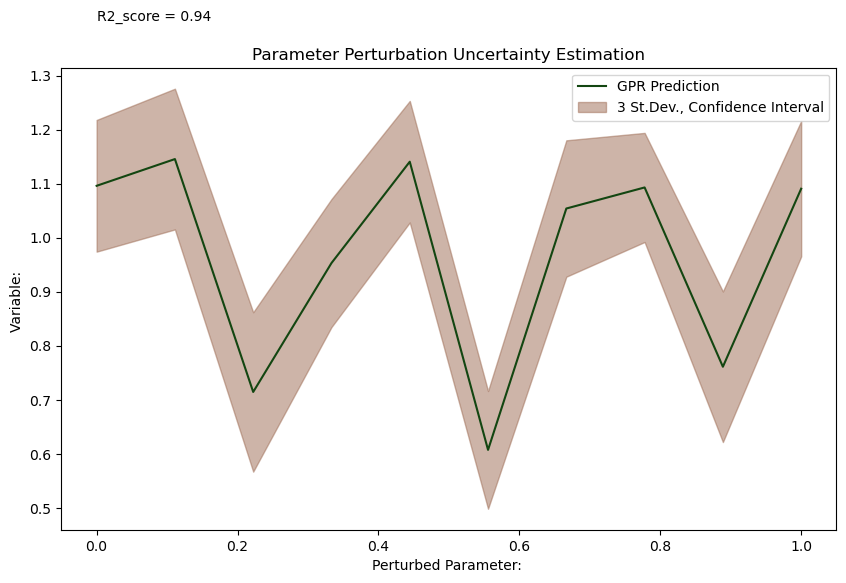

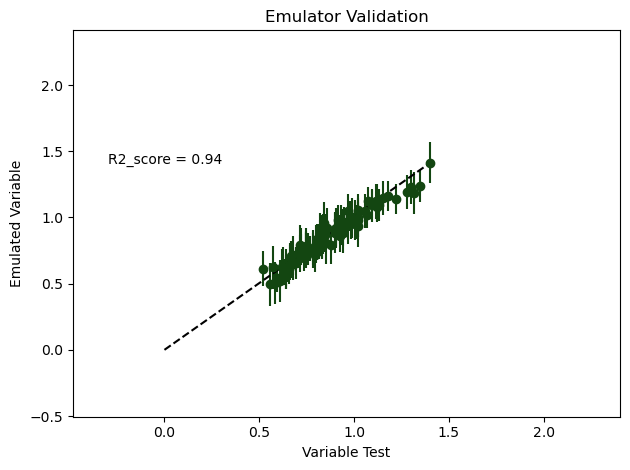

In [3]:
dashboard_wrangling("leafcn","LNC")

### Added this code to `utils.py`

In [ ]:
def dashboard_wrangling(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        var_da = subset_var_cluster(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
        var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
        ds = var_avg.to_dataset(name = var)
        ds.to_netcdf('saves/'+var+'.nc') # note that this will throw error if you try to overwrite existing files

    return train_emulator(params, var_avg)

In [ ]:
# Create an array that sets the value of all 32 parameters to 0.5
# this will be used when plotting emulation
X_values = np.full((10, 32), 0.5)  # Fill array with 0.5

def train_emulator(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Split Data 90/10        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # data for splitting
    X_train, X_test, y_train, y_test = train_test_split(param,
                                                        var,
                                                        test_size=0.2,
                                                        # setting a seed
                                                        random_state=0)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----    Kernel Specs No Tuning    ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # initiate the model without tuning
    kernel = ConstantKernel(constant_value = 3,
                            constant_value_bounds=(1e-2, 1e4)) \
                  * RBF(length_scale=1, 
                        length_scale_bounds=(1e-4, 1e8))

    gpr_model = GaussianProcessRegressor(kernel=kernel,
                                        n_restarts_optimizer=20,
                                        random_state=42,
                                        normalize_y=True)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Fit the Model        ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Fit the model to the training data
    gpr_model = gpr_model.fit(X_train, y_train)

    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Get Predictions      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Make predictions
    y_pred, y_std = gpr_model.predict(X_test, return_std=True)


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----         Collect Metrics      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Verify training score
    train_score = gpr_model.score(X_train, y_train)

    # Accuracy Score
    #accuracy = accuracy_score(y_test, y_pred)

    # Calculate Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    
    # Calculate R^2
    r2_train = r2_score(y_test, y_pred)
    
    # Calculate RMSE
    rmse_train = np.sqrt(mean_squared_error(y_test, y_pred))

    # Create a DataFrame to store the results for plotting
    results_df = pd.DataFrame({
        'y_pred': y_pred,
        'y_std': y_std,
        'y_test': y_test,
        'X_test': [x.tolist() for x in X_test],  # Convert array to list for DataFrame
    })

    # Add metrics to the DataFrame
    results_df['R^2'] = r2_train
    results_df['RMSE'] = rmse_train
    #results_df['Accuracy Score'] = accuracy
    results_df['Mean Absolute Error'] = mae
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Pickle Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # work in progress in GaiaFuture/Scripts/ML/Gaussian/gpr_pickling.ipynb



    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----        Print Metrics         ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Print Training Metrics
  #  print("Accuracy Score:", accuracy)
    print("Training R^2:", r2_train)
    print("Training RMSE:", rmse_train)
    print("Mean Absolute Error:", mae)
    print("Training Score:", train_score)

    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Visualize Emulation     ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # Calculate the z-score for the 99.7% confidence interval
    # 99.7th percentile (three standard deviations)
    z_score = norm.ppf(0.99865)  
    
    #For the parameter of interest, replace the 0.5 with a range of values between 0 and 1
    X_values[:, 15] = np.linspace(0, 1, 10)  # Set the 15th column values to evenly spaced values from 0 to 1
    coef_deter = r2_score(y_test,y_pred)

    
    # Plot the results
    plt.figure(figsize=(10, 6))
    
    plt.plot(X_values[:, 15],
             y_pred[:10,],
             color='#134611',
             label='GPR Prediction')

    plt.text(0,np.max(y_test),
             'R2_score = '+str(np.round(coef_deter,2)),
             fontsize=10)
    
    # applying z-score for 99.7% CI
    plt.fill_between(X_values[:, 15],
                     y_pred[:10] - z_score * y_std[:10], y_pred[:10] + z_score * y_std[:10],
                     alpha=0.5, 
                     color='#9d6b53',
                     label = '3 St.Dev., Confidence Interval')

   
    
    plt.xlabel('Perturbed Parameter: ')
    plt.ylabel('Variable: ')
    plt.title('Parameter Perturbation Uncertainty Estimation')
    
    plt.legend()
    plt.show()


    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # ----      Visualize Accuracy      ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~  
    plt.errorbar(y_test,
                 y_pred,
                 yerr=3*y_std,
                 fmt="o",
                 color='#134611')
    
    plt.text(-0.3,np.max(y_test),
             'R2_score = '+str(np.round(coef_deter,2)),
             fontsize=10)
    
    plt.plot([0,np.max(y_test)],
             [0,np.max(y_pred)],
             linestyle='--',
             c='k')
    
    plt.xlim([np.min(y_test)-1,np.max(y_test)+1])
    plt.ylim([np.min(y_pred)-1,np.max(y_pred)+1])

    plt.xlabel('Variable Test')
    plt.ylabel('Emulated Variable')
    plt.title('Emulator Validation')
    
    plt.tight_layout()

    return plt.show()

### Heather's Last chunk

In [ ]:
def dashboard_wrangling(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        var_da = subset_var_cluster(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
        var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
        ds = var_avg.to_dataset(name = var)
        ds.to_netcdf('saves/'+var+'.nc') # note that this will throw error if you try to overwrite existing files

    results_df = train_emulator(params, var_avg)

    Plot1 = accuracy_plot(results_df) 
    Plot2 = emulator_plot(results_df)
    
    return Plot1, Plot2

In [ ]:
dashboard_wrangling('leafcn', 'LNC');

# End of working function

# Issue: I can only make one output, plots 2 but only top figure updates

In [ ]:
def dashboard_wrangling_check(param, var):
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        var_da = subset_var_cluster(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
        var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
        ds = var_avg.to_dataset(name = var)
        ds.to_netcdf('saves/'+var+'.nc') # note that this will throw error if you try to overwrite existing files

    results_df = train_emulator(params, var_avg)
    
    Plot1 = accuracy_plot(results_df)
    plot1 = pn.pane.Matplotlib(Plot1)
    #Plot2 = emulator_plot(results_df)
    #plot2 = pn.pane.Matplotlib(Plot1)
    
    return plot1

In [ ]:
class Selections(param.Parameterized):
    parameter   = param.Selector(objects=['leafcn'])
    variable   = param.Selector(objects=['GPP', 'NBP', 'TOTVEGC', 'TLAI', 'EFLX_LH_TOT', 'SOILWATER_10CM', 'QRUNOFF', 'FSR', 'FAREA_BURNED', 'SNOWDP'])
    
    def view(self):
        return dashboard_wrangling_check(self.parameter, self.variable)

In [ ]:
obj = Selections()
pn.Row(obj.param, obj.view)

# Isssue:

In [ ]:
def dashboard_wrangling_check2(param, var):
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----            Parameter Data.          ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
    params = param_wrangling()
    
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    #----        If-else Load Data       ----
    #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
    
    filepath = os.path.join("saves", f"{var}.nc")
    if os.path.exists(filepath):
         #read in the file as a dataset
        ds=xr.open_dataset('saves/'+var+'.nc')
    
        #then convert back to data array
        var_avg = ds[var]
    else:
        print(f"Reading and wrangling your data, this may take a few minutes")
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----    Subset User Selection Funct     ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        var_da = subset_var_cluster(var)

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # ----      Subset Var Wrangle Funct      ----
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        # NEED TO ADD NAME ATTRIBUTE IN WRANGLING PORTION
        var_avg = wrangle_var_cluster(var_da)

        #you ought to convert the data array to dataset before writing to file
        ds = var_avg.to_dataset(name = var)
        ds.to_netcdf('saves/'+var+'.nc') # note that this will throw error if you try to overwrite existing files

    results_df = train_emulator(params, var_avg)
    
    Plot1 = accuracy_plot(results_df)
    Plot2 = emulator_plot(results_df)
    
    return Plot1, Plot2

In [ ]:
dashboard_wrangling_check2('leafcn', 'FSR')

In [ ]:
class Selections(param.Parameterized):
    parameter = param.Selector(objects=['leafcn'])
    variable = param.Selector(objects=['GPP', 'NBP', 'TOTVEGC', 'TLAI', 'EFLX_LH_TOT', 'SOILWATER_10CM', 'QRUNOFF', 'FSR', 'FAREA_BURNED', 'SNOWDP'])

    def view(self):
        # Call dashboard_wrangling with the selected parameter and variable
        plots = dashboard_wrangling_check2(self.parameter, self.variable)

        # Convert Matplotlib figures to Panel objects
        plot_pane1 = pn.pane.Matplotlib(plots[0])
        plot_pane2 = pn.pane.Matplotlib(plots[1])

        # Return a Panel layout containing the converted Panel objects
        return pn.Column(plot_pane1, plot_pane2)

# Create an instance of Selections and display it using Panel
obj = Selections()
pn.Row(obj.param, obj.view).servable()